In [2]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json

load_dotenv()

# Initialize model
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

# Send a query
response = model.invoke("Tell me a joke.")

# Print just the text response
print(response.content)


Why don't scientists trust atoms?

Because they make up everything!


In [3]:
search_tool = TavilySearchResults(max_results=4)

tools = [search_tool]
print(search_tool.run("What is the weather in bangalore?"))

memory = MemorySaver()


C:\Users\asus laptop\AppData\Local\Temp\ipykernel_8036\2307229908.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=4)


[{'title': '10-day weather forecast for Bengaluru, Karnataka, India', 'url': 'https://weather.com/en-PW/weather/tenday/l/e5e5d9e304a310cd9f5387b75551e92f5e8cab07d343b649a100e4096931e227', 'content': 'Showers. Low 20°C. Winds W at 10 to 15 km/h. Chance of rain 60%.\n\n   Humidity 86% \n   UV Index 0 of 11 \n   Moonrise-- \n   Moonset 13:29 \n   Waning Crescent  \n\nAdvertisement\n\nRadar\n\nNow\n\n© 2025 Mapbox© OpenStreetMap|Improve this map\n\nAdvertisement\n\nAdvertisement\n\nAdvertisement\n\nAdvertisement\n\nImage 1: The Weather CompanyImage 2: The Weather ChannelImage 3: Weather UndergroundImage 4: Storm Radar\n\n   Feedback\n   Weather API\n   News Room\n   Weather Data APIs [...] Partly cloudy. Low 20°C. Winds W at 10 to 15 km/h.\n\n   Humidity 87% \n   UV Index 0 of 11 \n   Moonrise 16:00 \n   Moonset 02:42 \n   Waxing Gibbous  \n\nFri 05\n\nPM T-Storms\n\n28°/20°\n\n42%\n\nW 21 km/h\n\nDay\n\n28°\n\n42%\n\nW 21 km/h\n\nThunderstorms developing in the afternoon. High 28°C. Winds

In [4]:
llm_with_tools = model.bind_tools(tools)



In [5]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
     # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)
    

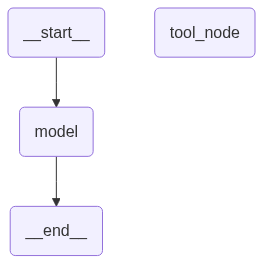

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)


In [7]:
config = {
    "configurable": {
        "thread_id": 5
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="When is the next spaceX launch?")], 
}, config=config)

response

{'messages': [HumanMessage(content='When is the next spaceX launch?', additional_kwargs={}, response_metadata={}, id='1ff7fa47-7021-4f1a-a955-1aae29df68f2'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "next SpaceX launch"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--9ce828f1-91c4-4714-b7d4-b1d261246a4e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'next SpaceX launch'}, 'id': '358540b9-370c-4fa3-a9a0-44f8d087a507', 'type': 'tool_call'}], usage_metadata={'input_tokens': 82, 'output_tokens': 119, 'total_tokens': 201, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 96}}),
  ToolMessage(content='[{\'title\': \'SpaceX Launch Manifest\', \'url\': \'https://nextspaceflight.com/launches/agency/upcoming/1/\', \'content\': \'Spac

In [8]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="When is the next spacex launch?")],
}, config=config, version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'bfb70f73-8fca-414f-85c0-a1481e043432', 'metadata': {'thread_id': 8}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={}, id='291eebac-944a-4e79-892e-db772679c125')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': 'd96a27dd-cb7e-4327-94c6-eb249fd8f7f2', 'metadata': {'thread_id': 8, 'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:3ebd541e-a4cf-2aad-8e4d-cd5460cf1e57'}, 'parent_ids': ['bfb70f73-8fca-414f-85c0-a1481e043432']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='When is the next spa